In [63]:
#Import library library python yang diperlukan untuk clustering
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt


In [64]:
#Membaca data train CSV yang diambil dari github saya dan menampilkan data samplenya
data_train = pd.read_csv("https://github.com/serlysetyani/gak-tau-apa/blob/main/kendaraan_train.csv?raw=true")
data_train.sample(5)

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
27323,27324,Wanita,45.0,1.0,NaN,0.0,NaN,Pernah,51688.0,14.0,190.0,1
101221,101222,Wanita,24.0,1.0,45.0,0.0,< 1 Tahun,Pernah,43384.0,152.0,291.0,0
283770,283771,Pria,65.0,1.0,28.0,1.0,1-2 Tahun,Tidak,44132.0,124.0,194.0,0
245586,245587,Wanita,43.0,1.0,50.0,0.0,1-2 Tahun,Pernah,41045.0,8.0,77.0,0
143369,143370,Wanita,20.0,1.0,17.0,1.0,< 1 Tahun,Tidak,34807.0,160.0,NaN,0


In [65]:
data_train.isna().sum()

id                       0
Jenis_Kelamin        14440
Umur                 14214
SIM                  14404
Kode_Daerah          14306
Sudah_Asuransi       14229
Umur_Kendaraan       14275
Kendaraan_Rusak      14188
Premi                14569
Kanal_Penjualan      14299
Lama_Berlangganan    13992
Tertarik                 0
dtype: int64

In [66]:
# Menghapus baris yang memiliki nilai kosong dan 
#melakukan pengecekan kembali apakah data missing sudah terhapus
df_train = data_train.dropna()
df_train.isna().sum()

id                   0
Jenis_Kelamin        0
Umur                 0
SIM                  0
Kode_Daerah          0
Sudah_Asuransi       0
Umur_Kendaraan       0
Kendaraan_Rusak      0
Premi                0
Kanal_Penjualan      0
Lama_Berlangganan    0
Tertarik             0
dtype: int64

In [67]:
#Melakukan pengecekan apakah dataset train terdapat data yang duplikat
df_train.duplicated().sum()

0

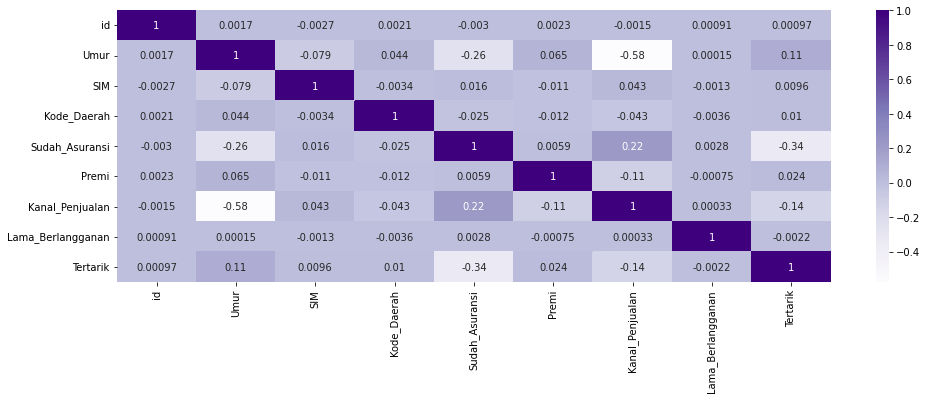

In [68]:
# Melihat korelasi data dengan menggunakan heatmap plot
corr_train = data_train.corr()
plt.figure(figsize = (16,5))
heatmap_train = sn.heatmap(corr_train, annot=True, cmap="Purples")
plt.show()

In [69]:
# Drop kolom yang tidak diperlukan
data_train = df_train.drop(labels=['id', 'Jenis_Kelamin', 'Umur_Kendaraan', 'Kendaraan_Rusak'], axis=1, inplace=False)
data_train.head(5)

,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,30.0,1.0,33.0,1.0,28029.0,152.0,97.0,0
1,48.0,1.0,39.0,0.0,25800.0,29.0,158.0,0
3,58.0,1.0,48.0,0.0,2630.0,124.0,63.0,0
5,21.0,1.0,35.0,1.0,22735.0,152.0,171.0,0
8,20.0,1.0,8.0,1.0,30786.0,160.0,31.0,0


In [70]:
# Melihat data type pada tiap kolom
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171068 entries, 0 to 285830
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur               171068 non-null  float64
 1   SIM                171068 non-null  float64
 2   Kode_Daerah        171068 non-null  float64
 3   Sudah_Asuransi     171068 non-null  float64
 4   Premi              171068 non-null  float64
 5   Kanal_Penjualan    171068 non-null  float64
 6   Lama_Berlangganan  171068 non-null  float64
 7   Tertarik           171068 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 11.7 MB


In [71]:
#Normalisasi data
norm_data_train = (data_train - data_train.min()) / (data_train.max() - data_train.min())
norm_data_train.head(5)

,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0.153846,1.0,0.634615,1.0,0.047251,0.932099,0.301038,0.0
1,0.430769,1.0,0.750000,0.0,0.043104,0.172840,0.512111,0.0
3,0.584615,1.0,0.923077,0.0,0.000000,0.759259,0.183391,0.0
5,0.015385,1.0,0.673077,1.0,0.037402,0.932099,0.557093,0.0
8,0.000000,1.0,0.153846,1.0,0.052380,0.981481,0.072664,0.0


In [72]:
# Mengambil kolom Umur dan kanal_penjualan
data = norm_data_train[['Umur', 'Kanal_Penjualan']]
data.head(5)

,Umur,Kanal_Penjualan
0,0.153846,0.932099
1,0.430769,0.172840
3,0.584615,0.759259
5,0.015385,0.932099
8,0.000000,0.981481


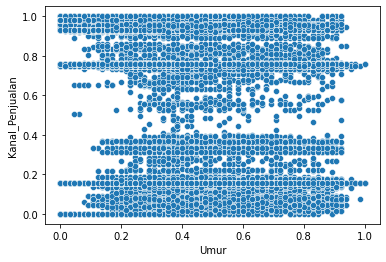

In [73]:
# Menggunakan scatter untuk melihat persebaran data Umur dan Kanal Penjualan
sn.scatterplot(data=data, x="Umur", y="Kanal_Penjualan")

In [74]:
x = data.values
x

array([[0.15384615, 0.93209877],
       [0.43076923, 0.17283951],
       [0.58461538, 0.75925926],
       ...,
       [0.04615385, 0.93209877],
       [0.73846154, 0.75925926],
       [0.38461538, 0.15432099]])

In [75]:
# Fungsi untuk menghitung WCSS
def calculate_wcss(x, centroids, cluster):
  sum = 0
  for i, val in enumerate(x):
    sum = sum + np.sqrt((centroids[int(cluster[i]), 0] - val[0]) ** 2 + (centroids[int(cluster[i]), 1] - val[1]) ** 2)
  return sum

In [76]:
# Proses Kmeans
def k_means(x, k):
  diff = 1
  cluster = np.zeros(x.shape[0])
  centroids = data.sample(n = k).values
  while diff:
    for i, row in enumerate(x):
      mn_dist = float('inf')
      for idx, centroid in enumerate(centroids):
        distance = np.sqrt((centroid[0] - row[0]) ** 2 + (centroid[1] - row[1]) ** 2)
        if distance <= mn_dist:
          mn_dist = distance
          cluster[i] = idx
    copy_centroids = pd.DataFrame(x).groupby(by = cluster).mean().values
    check_zero = np.count_nonzero(centroids - copy_centroids)
    if check_zero == 0:
      diff = 0
    else:
      centroids = copy_centroids
  return centroids, cluster

In [77]:
k = 4
centroids, cluster = k_means(x, k)

In [78]:
for i in range(k):
  print(f"Centroid ke {i + 1}", centroids[i])

Centroid ke 1 [0.34679383 0.80087713]
Centroid ke 2 [0.07800669 0.93479901]
Centroid ke 3 [0.47887564 0.15098947]
Centroid ke 4 [0.6598437  0.79816341]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


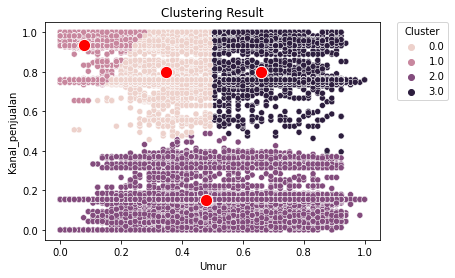

In [79]:
# Menampilkan hasil clustering dengan menggunakan scatter plot
sn.scatterplot(x[:,0], x[:, 1], hue=cluster)
sn.scatterplot(centroids[:,0], centroids[:, 1], s=150, color='red', markers="P")
plt.xlabel('Umur')
plt.ylabel('Kanal_penjualan')
plt.title('Clustering Result')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

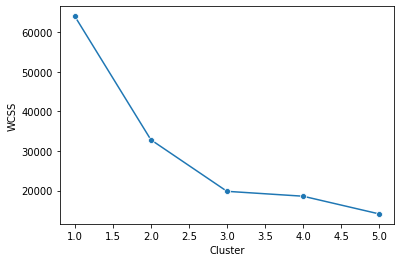

In [80]:
cost_list = []
for k in range(1, 6):
  centroids, cluster = k_means(x, k)
  cost_result = calculate_wcss(x, centroids, cluster)
  cost_list.append(cost_result)

sn.lineplot(x = range(1, 6), y = cost_list, marker = 'o')
plt.xlabel('Cluster')
plt.ylabel('WCSS')
plt.show()

In [123]:
for i in range(k):
  print(f"Result of WCSS {i + 1}: ", cost_list[i])

Result of WCSS 1:  19810.12759820972
Result of WCSS 2:  19809.811465315674
Result of WCSS 3:  19810.12759820972
Result of WCSS 4:  19810.12759820972
Result of WCSS 5:  19810.12759820972


# **Eksperimen 1 Dengan nilai k =5 👍**

In [112]:
k1 = 5
centroids, cluster = k_means(x, k1)

In [113]:
for i in range(k1):
  print(f"Result of WCSS {i + 1}: ", cost_list[i])

Result of WCSS 1:  15609.756989683941
Result of WCSS 2:  15592.924442385001
Result of WCSS 3:  15965.368263098957
Result of WCSS 4:  15592.924442385001
Result of WCSS 5:  14107.666027682173


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


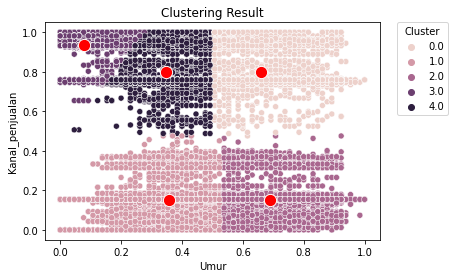

In [106]:
sn.scatterplot(x[:,0], x[:, 1], hue=cluster)
sn.scatterplot(centroids[:,0], centroids[:, 1], s=150, color='red', markers="P")
plt.xlabel('Umur')
plt.ylabel('Kanal_penjualan')
plt.title('Clustering Result')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

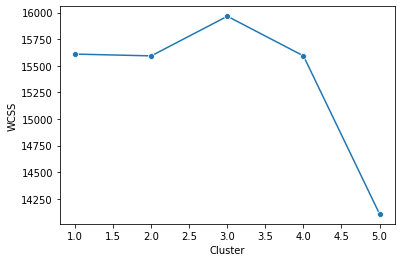

In [108]:
cost_list = []
for k in range(1, 6):
  centroids, cluster = k_means(x, k1)
  cost_result = calculate_wcss(x, centroids, cluster)
  cost_list.append(cost_result)

sn.lineplot(x = range(1, 6), y = cost_list, marker = 'o')
plt.xlabel('Cluster')
plt.ylabel('WCSS')
plt.show()

# **Eksperimen 2 Dengan Nilai k = 3 👍**

In [114]:
k2 = 3
centroids, cluster = k_means(x, k2)

In [115]:
for i in range(k2):
  print(f"Result of WCSS {i + 1}: ", cost_list[i])

Result of WCSS 1:  15609.756989683941
Result of WCSS 2:  15592.924442385001
Result of WCSS 3:  15965.368263098957


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


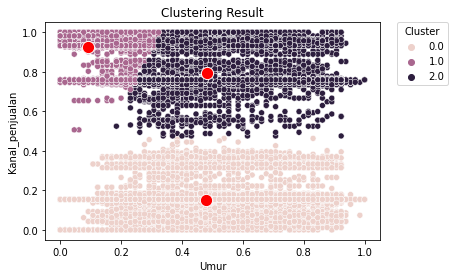

In [116]:
sn.scatterplot(x[:,0], x[:, 1], hue=cluster)
sn.scatterplot(centroids[:,0], centroids[:, 1], s=150, color='red', markers="P")
plt.xlabel('Umur')
plt.ylabel('Kanal_penjualan')
plt.title('Clustering Result')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

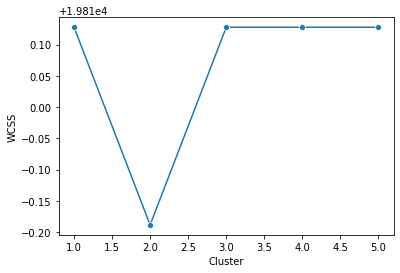

In [122]:
cost_list = []
for k in range(1, 6):
  centroids, cluster = k_means(x, k2)
  cost_result = calculate_wcss(x, centroids, cluster)
  cost_list.append(cost_result)

sn.lineplot(x = range(1, 6), y = cost_list, marker = 'o')
plt.xlabel('Cluster')
plt.ylabel('WCSS')
plt.show()